# 0 Preparación del entorno.

## 0.1 Definición de parámetros

In [1]:
tfm_path='TFM data/'
H1_code = 'OMNI2_H0_MRG1HR'
M5_code = 'OMNI_HRO2_5MIN'
lookback = 12
lookforward = 6
tfm_path_Nh_models = f'PRED_{lookforward}h/'
cols_to_use = ['Bx', 'By_gse', 'Bz_gse', 'By_gsm', 'Bz_gsm', 'P_density', 'E_field', 'plasma_T', 'plasma_V', 'Dst'] # 'AP', out
col_to_predict = "Dst"
hstorms_data = 'historical_storms_gruet2018.csv'
weak_threshold = -30 #1
moderate_threshold = -50 #2
strong_threshold = -100 #3
severe_threshold = -200 #4
great_threshold = -300 #5
gamma_value=0.0001
temporal_margin=5*24 # margen para obtener tiempos ampliados de las tormentas de gruet et al 2018
test_size = 0.2
val_size = 0.2
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

In [2]:
PATH_NN_RES_BY_STORM = "NN_{}h_res_by_storm/storm_{}.csv"
PATH_NN_RES_BY_STORM_PLOTS = "NN_{}h_res_by_storm/storm_{}.png"

## 0.2 Montar Google Drive (obtención de datos)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# !rm -rf sample_data/

## 0.3 Importación de librerías

In [4]:
# !pip install optuna

In [5]:
import os

import numpy as np

# librerías de manipulación de datos y gráficos
import pandas as pd
import matplotlib.dates as mdates
import numpy as np

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# modelo
from sklearn.svm import SVR
#from thundersvm import SVR
# escalado y división en train/test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# obtención de métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.metrics import explained_variance_score, max_error

# meta
# timer
import time

#optuna
import optuna
import optuna_dashboard
from sklearn.model_selection import cross_val_score

import tensorflow as tf

2024-07-20 18:51:55.539472: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 18:51:55.720485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 18:51:55.830571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 18:51:55.831142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 18:51:55.969378: I tensorflow/core/platform/cpu_feature_gua

In [6]:
tf.config.list_physical_devices('GPU')

2024-07-20 18:51:58.871978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 18:51:59.164762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 18:51:59.165148: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 0.4 Definición de funciones

In [7]:
def exploracion_inicial_datos(df):
    """
    Función para realizar una exploración inicial de los datos.

    Parámetros:
    df (dataframe): El dataframe que contiene los datos.

    Muestra las primeras filas, estadísticas descriptivas, valores faltantes,
    histogramas de variables numéricas y un mapa de calor de la correlación.
    """
    # Configuración de visualización
    sns.set(style="whitegrid")  # Estilo de gráficos


    print("Primeras filas del DataFrame:")
    print(df.head())


    print("\nDescripción estadística de los datos:")
    print(df.describe())


    print("\nValores faltantes por columna:")
    print(df.isnull().sum())


    print("\nVisualización de histogramas para variables numéricas:")
    df.hist(bins=15, figsize=(15, 10), layout=(5, 4))
    plt.show()
    print("\nMapa de calor de la matriz de correlación:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()


def calcular_layout_optimo(num_cols):
    """
    Calcula el número óptimo de filas y columnas para una figura con subgráficos,
    tratando de mantener una forma que sea visualmente agradable y que aproveche el espacio.

    Parámetros:
    num_cols (int): Número total de columnas (gráficos) a mostrar.

    Retorna:
    (int, int): Número de filas y columnas para el layout de los subgráficos.
    """
    # Calcula el número óptimo de columnas teniendo un límite visual razonable
    cols_per_row = int(np.sqrt(num_cols)) + 1  # Ajuste para maximizar el uso del espacio y la forma de la figura
    rows_needed = (num_cols + cols_per_row - 1) // cols_per_row  # Redondeo hacia arriba para incluir todas las columnas
    return rows_needed, cols_per_row

def exploracion_histogramas(df):
    """
    Función para generar histogramas para todas las columnas numéricas en un DataFrame,
    excluyendo las columnas de tipo datetime y no numéricas.

    Parámetros:
    df (DataFrame): DataFrame de pandas con los datos a analizar.
    """
    # Eliminar columnas no numéricas y de tipo datetime
    df_numerico = df.select_dtypes(include=[np.number])

    # Número de columnas numéricas
    num_cols = df_numerico.shape[1]

    # Verificar si hay columnas para mostrar
    if num_cols == 0:
        print("No hay columnas numéricas para mostrar.")
        return

    # Calculando el layout necesario
    rows_needed, cols_per_row = calcular_layout_optimo(num_cols)

    # Crear histogramas
    df_numerico.hist(bins=15, figsize=(15, 10), layout=(rows_needed, cols_per_row))
    plt.show()

def imputar_nan(df):
  df.interpolate(method='linear', inplace=True)
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)
  if sum(df.isnull().sum())!=0:
    print("Faltan nulos por tratar")
  return df

def visualizar_nulos_plot(df, variable_with_nans):
    """
    Plot the specified 'variable_with_nans' column and 'Dst' column from the DataFrame.

    Parameters:
    - df: pandas.DataFrame containing the data to plot.
    - variable_with_nans: str, the name of the column in the DataFrame to plot, which may contain NaNs.

    The function assumes that 'Dst' is a column name in the DataFrame and that the DataFrame's index is suitable for plotting (e.g., datetime).
    """
    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 8))

    # Handling NaNs in the 'variable_with_nans' column before plotting
    df_plot = df.copy()
    df_plot[variable_with_nans] = df_plot[variable_with_nans].fillna(method='ffill')  # Forward fill to handle NaNs

    # Plotting 'variable_with_nans' on the first subplot
    ax1.scatter(df_plot.index, df_plot[variable_with_nans], label=variable_with_nans, color='blue')
    ax1.set_ylabel(variable_with_nans)
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plotting 'Dst' on the second subplot
    ax2.plot(df_plot.index, df_plot['Dst'], label='Dst', color='red')
    ax2.set_ylabel('Dst')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    # Setting the x-axis label only on the bottom subplot
    ax2.set_xlabel('Datetime')

    # Improve layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example of how to use this function with a DataFrame containing NaNs
data = {
    'Datetime': pd.date_range(start='2021-01-01', periods=100, freq='D'),
    'variable_with_nans': pd.Series(range(100)).where(lambda x : x % 10 != 0),
    'Dst': range(100, 0, -1)
}
df = pd.DataFrame(data)
df.set_index('Datetime', inplace=True)

def create_window_df_nn(list_dfs, lookback, lookforward, cols_to_use, col_to_predict, scaler_label=None):
    """
    Creates input and output datasets for NN training from a list of DataFrames, incorporating windowing and optional descaling for target

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to process.
    lookback (int): Number of past records to include as features for each prediction.
    lookforward (int): Number of records ahead to predict.
    cols_to_use (list of str): List of column names to use as features.
    col_to_predict (str): Column name to predict.
    scaler_label (StandardScaler, optional): Scaler for the output variable, used for inverse transformation.

    Returns:
    tuple: A tuple containing arrays for training features and labels.
    """
    x_train, y_train = [], []

    for df_ in list_dfs:
        df = df_.copy()

        for i in range(len(df) - lookback - lookforward + 1):
            x_train.append(np.asarray(df.iloc[i:i+lookback][cols_to_use].values))
            y_train.append(np.asarray(df.iloc[i+lookback][col_to_predict]))

    if scaler_label is not None:
        y_train = scaler_label.inverse_transform(np.asarray(y_train).reshape(-1,1))

    return np.asarray(x_train), np.asarray(y_train)


def filter_storms(df, historical_storms, temporal_margin):
    """
    Filter DataFrame entries based on the occurrence of storms within specific time intervals.

    Parameters:
    df (pandas.DataFrame): DataFrame containing time-series data with a 'Datetime' column.
    historical_storms (pandas.DataFrame): DataFrame containing the start and end times of historical storms.
    temporal_margin (int): Number of rows before and after the minimum Dst index to include in the result.

    Returns:
    list: A list of DataFrame snippets corresponding to the specified storm intervals.
    """
    all_storms = []
    for i in range(len(historical_storms)):
        df_tmp = df[(df["Datetime"] >= historical_storms.iloc[i]["start"]) & (df["Datetime"] <= historical_storms.iloc[i]["end"])]
        idx = df_tmp['Dst'].idxmin()
        all_storms.append(df.iloc[idx-temporal_margin:idx+temporal_margin])
    return all_storms

def combinar_dataframes_solapados(dfs):
    """
    Combines overlapping DataFrames in a list into non-overlapping DataFrames based on the 'Datetime' column.

    Parameters:
    dfs (list of pandas.DataFrame): List of DataFrames to combine.

    Returns:
    list: A list of combined DataFrames without overlap.
    """
    dfs.sort(key=lambda x: x['Datetime'].min())
    combinados = []
    combinacion_actual = dfs[0]

    for df in dfs[1:]:
        if df['Datetime'].min() <= combinacion_actual['Datetime'].max():
            combinacion_actual = pd.concat([combinacion_actual, df]).drop_duplicates().sort_values(by='Datetime')
        else:
            combinados.append(combinacion_actual)
            combinacion_actual = df
    combinados.append(combinacion_actual)
    return combinados

def scale_data(list_dfs, cols_to_use, col_to_predict):
    """
    Scales columns in a list of DataFrames using StandardScaler.

    Parameters:
    list_dfs (list of pandas.DataFrame): List of DataFrames to scale.
    cols_to_use (list of str): Column names to apply scaling to.
    col_to_predict (str): Column name used as a label for prediction.

    Returns:
    tuple: A tuple containing the list of scaled DataFrames and the label scaler.
    """
    list_dfs_ = []
    scaler_cols = StandardScaler()
    scaler_label = StandardScaler()
    scaler_cols.fit(pd.concat(list_dfs)[cols_to_use])
    scaler_label.fit(np.asarray(pd.concat(list_dfs)[col_to_predict]).reshape(-1,1))

    for df_ in list_dfs:
        df = df_.copy()
        df[cols_to_use] = scaler_cols.transform(df[cols_to_use])
        list_dfs_.append(df)

    return list_dfs_, scaler_label



def calc_metrics(predictions, y_test):
  # Mean Squared Error
  mse = mean_squared_error(y_test, predictions)
  # Mean Absolute Error
  mae = mean_absolute_error(y_test, predictions)
  # R^2 Score, the coefficient of determination
  r2 = r2_score(y_test, predictions)
  # Median Absolute Error
  medae = median_absolute_error(y_test, predictions)
  # Explained Variance Score
  explained_variance = explained_variance_score(y_test, predictions)
  # Max Error
  max_err = max_error(y_test, predictions)

  return mse, mae, r2, medae, explained_variance, max_err


def formatear_tiempo(segundos):
    horas = int(segundos // 3600)
    minutos = int((segundos % 3600) // 60)
    segundos = segundos % 60
    return f"{horas} horas, {minutos} minutos, {segundos:.2f} segundos"


Función para extraer las fechas de la nueva división de datos, una vez ampliadas las ventanas de cada tormenta a +-5 días desde el mínimo de cada tormenta, y eliminados los datos solapados

In [8]:
def get_new_splits_dates(all_storms):
    dates_start = []
    dates_end = []
    num_storm = []
    min_dst_values = []
    
    for idx, df in enumerate(all_storms):
        dates_start.append(df["Datetime"].iloc[0])
        dates_end.append(df["Datetime"].iloc[-1])
        num_storm.append(idx+1)
        min_dst_values.append(df["Dst"].min())
    df_new_storms = pd.DataFrame(
        {
            "storm_index": num_storm,
            "date_start": dates_start,
            "date_end": dates_end,
            "min_DST": min_dst_values
        }
    )
    return df_new_storms

Función para sacar los scalers de las variables de input y de la label (Dst)

In [9]:
def get_scalers(list_dfs, cols_to_use, col_to_predict):
    list_dfs_ = []
    scaler_cols = StandardScaler()
    scaler_label = StandardScaler()
    scaler_cols.fit(pd.concat(list_dfs)[cols_to_use])
    scaler_label.fit(np.asarray(pd.concat(list_dfs)[col_to_predict]).reshape(-1,1))

    return scaler_cols, scaler_label

Nueva función para crear ventanas de datos para input del modelo

In [10]:
def create_window_df_nn(list_dfs, lookback, lookforward, cols_to_use, col_to_predict, scaler_cols):
    x_train, y_train = [], []

    for df_ in list_dfs:
        df = df_[cols_to_use].copy()
        df.loc[:, cols_to_use] = scaler_cols.transform(df[cols_to_use])

        for i in range(len(df) - lookback - lookforward + 1):
            x_train.append(np.asarray(df.iloc[i:i+lookback].values))
            y_train.append(np.asarray(df.iloc[i+lookback+lookforward-1][col_to_predict]))

    return np.asarray(x_train), np.asarray(y_train)

def create_window_df_nn_test(list_dfs, lookback, lookforward, cols_to_use, col_to_predict, scaler_cols):
    x_train, y_train, date_pred, date_last_data = [], [], [], []

    for df_ in list_dfs:
        df = df_.copy()
        df.loc[:, cols_to_use] = scaler_cols.transform(df[cols_to_use])

        for i in range(len(df) - lookback - lookforward + 1):
            x_train.append(np.asarray(df.iloc[i:i+lookback][cols_to_use].values))
            y_train.append(np.asarray(df.iloc[i+lookback+lookforward-1][col_to_predict]))
            date_last_data.append(df.iloc[i+lookback-1]["Datetime"])
            date_pred.append(df.iloc[i+lookback+lookforward-1]["Datetime"])

    return np.asarray(x_train), np.asarray(y_train), np.asarray(date_last_data), np.asarray(date_pred)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from math import sqrt
import sklearn

def error_nn(y_pred, y_true, index_scaler):
    y_pred = index_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_true = index_scaler.inverse_transform(y_true.reshape(-1, 1))
    
    print(y_pred.reshape(-1).shape)
    print(y_true.reshape(-1).shape)
    df_ = pd.DataFrame({"y_pred": y_pred.reshape(-1), "y_true": y_true.reshape(-1)})
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Median Absolute Error
    medae = median_absolute_error(y_true, y_pred)
    # Explained Variance Score
    explained_variance = explained_variance_score(y_true, y_pred)
    # Max Error
    max_err = max_error(y_true, y_pred)
    
    
    data = {
        'Métrica': ['RMSE', 'MSE', 'MAE', 'R²', 'MedAE', 'Varianza explicada', 'Max error'],
        'Valor': [rmse, mse, mae, r2, medae, explained_variance, max_err]
    }
    df = pd.DataFrame(data)
    df_invertido = df.transpose()
    df_invertido.columns = df_invertido.iloc[0]
    df_invertido = df_invertido[1:]
    display(df_invertido)
    
    # scatter plot
    plt.figure(figsize=(8, 4))
    plt.scatter(y_true, y_pred, c='blue', label='Predicciones vs. Valores reales')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2, label='Línea de referencia')
    plt.xlabel('Valores reales')
    plt.ylabel('Predicciones')
    plt.title('Diagrama de dispersión de Predicciones vs. Valores reales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return 

In [12]:
def evaluate_svr_models(X_train, y_train, X_test, y_test, kernels, C_values, epsilon_values, gamma_values, degree_values, verbose=True):
    """
    Evaluate SVR models with different hyperparameter configurations and kernel types.

    Args:
    X_train (array): Independent training data.
    y_train (array): Dependent training data (target).
    X_test (array): Independent test data.
    y_test (array): Dependent test data (target).
    kernels (list): List of kernel types to evaluate.
    C_values (list): List of values for the penalty parameter C.
    epsilon_values (list): List of values for the epsilon parameter.
    gamma_values (list): List of values for the gamma parameter.
    degree_values (list): List of values for the degree parameter (used only in polynomial kernels).
    verbose (bool, optional): If True, prints messages during the evaluation process. Default is True.

    Returns:
    DataFrame: A pandas DataFrame containing evaluation metrics for each parameter configuration.
    dict: A dictionary of trained models, with keys describing the specific parameter configuration.

    Note:
    Assumes that the 'precomputed' kernel is only used if the 'precomputed_matrix' is defined in the local environment.
    """
    results = []
    models_dict = {}

    for kernel_ in kernels:
        for C in C_values:
            for epsilon in epsilon_values:
                # Check parameter relevance for gamma and degree for the current kernel
                relevant_gamma_values = gamma_values if kernel_ in ['rbf', 'sigmoid', 'poly'] else [None]
                relevant_degree_values = degree_values if kernel_ == 'poly' else [None]

                for gamma in relevant_gamma_values:
                    for degree in relevant_degree_values:
                        start = time.time()
                        config_key = f"{kernel_}_C{C}_eps{epsilon}_gamma{gamma}_deg{degree}"
                        if verbose:
                            print(f"Starting {config_key}")

                        if kernel_ == "precomputed":
                            if 'precomputed_matrix' in locals():
                                model = SVR(kernel='precomputed', C=C, epsilon=epsilon)
                                model.fit(precomputed_matrix, y_train)
                                models_dict[config_key] = model
                                continue
                            else:
                                if verbose:
                                    print("Precomputed matrix not defined for kernel='precomputed'")
                                continue

                        model = SVR(kernel=kernel_, C=C, epsilon=epsilon, gamma=(gamma if gamma is not None else 0.01), degree=(degree if degree is not None else 3))
                        model.fit(X_train, y_train)
                        models_dict[config_key] = model

                        predictions = model.predict(X_test)
                        mse, mae, r2, medae, explained_variance, max_err = calc_metrics(predictions, y_test)
                        end = time.time()
                        time_exec = formatear_tiempo(end - start)

                        results.append({
                            "kernel": kernel_,
                            "C": C,
                            "epsilon": epsilon,
                            "gamma": gamma,
                            "degree": degree,
                            "mse": mse,
                            "mae": mae,
                            "r2": r2,
                            "medae": medae,
                            "exp_var": explained_variance,
                            "max_err": max_err,
                            "time_exec": time_exec
                        })

                        print(f"{config_key} finished. Time for iteration: {time_exec} | mae: {mae} | mse: {mse} | exp_var: {explained_variance} | max_err: {max_err}")

    df_results = pd.DataFrame(results)
    return df_results, models_dict


# 1. Carga y preparación de datos

## 1.1 Carga de los datos

In [13]:
hd = pd.read_csv(tfm_path+H1_code+'.csv', parse_dates=["Datetime"])
# md = pd.read_csv(tfm_path+M5_code+'.csv', parse_dates=["Datetime"]) # no se va a usar por ahora
historical_storms = pd.read_csv(tfm_path+hstorms_data)
# historical_storms = historical_storms.drop(columns=['Min. Dst (nT)','Unnamed: 0'], axis=1)

- Ver qué columnas y tipo de datos contienen los df.

In [14]:
hd.columns

Index(['ID_IMF', 'ID_plasma', 'Bmag', 'dev_Bmag', 'Bx', 'By_gse', 'Bz_gse',
       'By_gsm', 'Bz_gsm', 'dev_Bx', 'dev_By', 'dev_Bz', 'P_density',
       'dev_P_density', 'AP', 'dev_AP', 'E_field', 'plasma_T', 'dev_plasma_T',
       'plasma_V', 'Dst', 'Datetime'],
      dtype='object')

In [15]:
hd.dtypes

ID_IMF                  float64
ID_plasma               float64
Bmag                    float64
dev_Bmag                float64
Bx                      float64
By_gse                  float64
Bz_gse                  float64
By_gsm                  float64
Bz_gsm                  float64
dev_Bx                  float64
dev_By                  float64
dev_Bz                  float64
P_density               float64
dev_P_density           float64
AP                      float64
dev_AP                  float64
E_field                 float64
plasma_T                float64
dev_plasma_T            float64
plasma_V                float64
Dst                     float64
Datetime         datetime64[ns]
dtype: object

In [16]:
historical_storms.columns

Index(['Unnamed: 0', 'Min. Dst (nT)', 'start', 'end', 'storm'], dtype='object')

In [17]:
historical_storms.dtypes

Unnamed: 0        int64
Min. Dst (nT)     int64
start            object
end              object
storm             int64
dtype: object

- Ordenar las tormentas en caso de que no lo estén
- Convertir todas las fechas a datetime de pd.

In [18]:
# Ordenar los dataframes por fecha
historical_storms = historical_storms.sort_values(by='start')

# convertir las columnas de tiempo a datetime64
hd['Datetime']=pd.to_datetime(hd['Datetime'])
historical_storms['start']=pd.to_datetime(historical_storms['start'])
historical_storms['end']=pd.to_datetime(historical_storms['end'])

# Cuando se utilizan los datos a 5 minutos, se unen a 5min
#data = pd.merge(md, hd[["Datetime", "Dst"]], on='Datetime', how='left')

## 1.2 Exploración inicial de los datos

- head del df

In [19]:
# hd.head()

- descripción estadística de los datos

In [20]:
# hd.describe()

- ver los valores nulos

In [21]:
# hd.isnull().sum()

In [22]:
# hd.isnull().sum() / len(hd) * 100

- Histograma para variables numéricas (todas, en este caso, pero hemos quitado datetime porque no es muy util al ser una serie temporal).

In [23]:
# exploracion_histogramas(hd)

- Visualizaciónd e historical_storms

In [24]:
# storms_data = historical_storms.copy()

In [25]:
# # Convertir las columnas de fecha y hora a datetime
# storms_data['start'] = pd.to_datetime(storms_data['start'])
# storms_data['end'] = pd.to_datetime(storms_data['end'])
# # Calcular la duración de cada tormenta en horas
# storms_data['duration_hours'] = (storms_data['end'] - storms_data['start']).dt.total_seconds() / 3600

# # Gráfico de la distribución de las intensidades mínimas de las tormentas
# plt.figure(figsize=(8, 4))
# sns.histplot(storms_data['Min. Dst (nT)'], bins=30, kde=True, color='blue')
# plt.title('Distribución de Intensidades Mínimas de Tormentas Geomagnéticas')
# plt.xlabel('Min. Dst (nT)')
# plt.ylabel('Frecuencia')
# plt.grid(True)
# plt.show()

Gráfico de dispersión entre la duración y la intensidad mínima

In [26]:
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='duration_hours', y='Min. Dst (nT)', data=storms_data)
# plt.title('Correlación entre Duración e Intensidad Mínima de Tormentas')
# plt.xlabel('Duración (Horas)')
# plt.ylabel('Min. Dst (nT)')
# plt.grid(True)
# plt.show()

- Ver el timeline de las tormentas

In [27]:
# import plotly.graph_objects as go

# # Crear la figura
# fig = go.Figure()

# # Añadir cada tormenta como un segmento de línea en el gráfico
# for i, row in storms_data.iterrows():
#     fig.add_trace(go.Scatter(
#         x=[row['start'], row['end']],
#         y=[i, i],
#         mode='lines+markers',
#         name=f"Tormenta {row['storm']}"
#     ))

# # Ajustar la presentación de la figura
# fig.update_layout(
#     title="Línea de Tiempo de Tormentas Históricas",
#     xaxis_title="Fecha",
#     yaxis_title="Tormenta",
#     yaxis=dict(
#         tickmode='array',
#         tickvals=list(range(len(storms_data)))
#     ),
#     showlegend=False,
#     xaxis=dict(
#         rangeslider=dict(
#             visible=True
#         ),
#         type="date"
#     )
# )

# # Mostrar la figura
# fig.show()

Mapa de calor de la matriz de correlación

In [28]:
# plt.figure(figsize=(15, 8))
# sns.heatmap(hd.corr(), annot=True, fmt=".2f", cmap='coolwarm')
# plt.show()

## 1.3 Limpieza y procesamiento de los datos

### 1.3.1 Tratamiento de valores faltantes

In [29]:
sum(hd.isnull().sum())

42472

In [30]:
hd = imputar_nan(hd)

/tmp/ipykernel_2082/1479166569.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_2082/1479166569.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [31]:
sum(hd.isnull().sum())

0

### 1.3.2 Normalización de los datos

In [32]:
all_storms = filter_storms(hd, historical_storms, temporal_margin)
all_storms = combinar_dataframes_solapados(all_storms)

In [33]:
historical_storms_new = get_new_splits_dates(all_storms)

Storm index de cada conjunto de datos, test y validación, entrenamiento el resto

In [34]:
index_test_storms = [2, 12, 23, 32, 8, 40, 42, 3, 31]
index_val_storms = [25, 13, 1, 37, 33, 7]

TORMENTAS DE ENTRENAMIENTO

In [35]:
train_storms = [df for idx, df in enumerate(all_storms) if idx not in [x-1 for x in index_test_storms]+[x-1 for x in index_val_storms]]
historical_storms_new[~historical_storms_new["storm_index"].isin(index_test_storms+index_val_storms)].reset_index(drop=True)

,storm_index,date_start,date_end,min_DST
0,4,2001-08-12 21:00:00,2001-08-22 20:00:00,-105.0
1,5,2001-09-26 08:00:00,2001-10-06 07:00:00,-166.0
2,6,2001-10-16 21:00:00,2001-11-02 10:00:00,-187.0
3,9,2002-05-06 19:00:00,2002-05-16 18:00:00,-110.0
4,10,2002-05-18 17:00:00,2002-05-28 16:00:00,-109.0
5,11,2002-07-28 05:00:00,2002-08-07 04:00:00,-102.0
6,14,2002-11-16 10:00:00,2002-11-26 09:00:00,-128.0
7,15,2003-05-24 23:00:00,2003-06-03 22:00:00,-144.0
8,16,2003-06-13 09:00:00,2003-06-23 08:00:00,-141.0
9,17,2003-07-07 05:00:00,2003-07-17 04:00:00,-105.0


TORMENTAS DE TEST

In [36]:
test_storms = [df for idx, df in enumerate(all_storms) if idx in [x-1 for x in index_test_storms]]
historical_storms_new[historical_storms_new["storm_index"].isin(index_test_storms)].reset_index(drop=True)

,storm_index,date_start,date_end,min_DST
0,2,2001-03-26 08:00:00,2001-04-05 07:00:00,-387.0
1,3,2001-04-13 06:00:00,2001-04-27 14:00:00,-114.0
2,8,2002-04-13 07:00:00,2002-04-25 07:00:00,-149.0
3,12,2002-08-30 05:00:00,2002-09-12 23:00:00,-181.0
4,23,2004-07-18 02:00:00,2004-08-01 12:00:00,-170.0
5,31,2006-04-09 09:00:00,2006-04-19 08:00:00,-98.0
6,32,2006-12-10 07:00:00,2006-12-20 06:00:00,-162.0
7,40,2013-03-12 20:00:00,2013-03-22 19:00:00,-132.0
8,42,2014-02-14 08:00:00,2014-02-24 07:00:00,-119.0


TORMENTAS DE VALIDACI

In [37]:
val_storms = [df for idx, df in enumerate(all_storms) if idx in [x-1 for x in index_val_storms]]
historical_storms_new[historical_storms_new["storm_index"].isin(index_val_storms)].reset_index(drop=True)

,storm_index,date_start,date_end,min_DST
0,1,2001-03-15 13:00:00,2001-03-25 12:00:00,-149.0
1,7,2002-03-19 09:00:00,2002-03-29 08:00:00,-100.0
2,13,2002-09-26 16:00:00,2002-10-06 15:00:00,-176.0
3,25,2004-11-07 10:00:00,2004-11-17 09:00:00,-374.0
4,33,2011-09-21 23:00:00,2011-10-01 22:00:00,-118.0
5,37,2012-07-10 16:00:00,2012-07-20 15:00:00,-139.0


Obtenemos scalers de input y label con todo el conjunto de datos

In [38]:
scaler_cols, scaler_label = get_scalers(all_storms, cols_to_use, col_to_predict)

Genereamos ventanas en el formato deseado de los conjuntos de entrenamiento test y validación

In [39]:
x_train, y_train = create_window_df_nn(train_storms, lookback, lookforward, cols_to_use, col_to_predict, scaler_cols)
print("x_train shape : ", x_train.shape, "\ny_train shape:", y_train.shape)

x_train shape :  (6375, 12, 10) 
y_train shape: (6375,)


In [40]:
x_test, y_test = create_window_df_nn(test_storms, lookback, lookforward, cols_to_use, col_to_predict, scaler_cols)
print("x_test shape : ", x_test.shape, "\ny_test shape:", y_test.shape)

x_test shape :  (2359, 12, 10) 
y_test shape: (2359,)


In [41]:
x_val, y_val = create_window_df_nn(val_storms, lookback, lookforward, cols_to_use, col_to_predict, scaler_cols)
print("x_val shape : ", x_val.shape, "\ny_val shape:", y_val.shape)

x_val shape :  (1338, 12, 10) 
y_val shape: (1338,)


### 1.3.3 Codificación de variables categóricas

* No existe codificación de variables categóricas porque **no hay variables categóricas). A continuación, se muestra.

In [42]:
pd.concat(all_storms).dtypes

ID_IMF                  float64
ID_plasma               float64
Bmag                    float64
dev_Bmag                float64
Bx                      float64
By_gse                  float64
Bz_gse                  float64
By_gsm                  float64
Bz_gsm                  float64
dev_Bx                  float64
dev_By                  float64
dev_Bz                  float64
P_density               float64
dev_P_density           float64
AP                      float64
dev_AP                  float64
E_field                 float64
plasma_T                float64
dev_plasma_T            float64
plasma_V                float64
Dst                     float64
Datetime         datetime64[ns]
dtype: object

# 3 Entrenamiento de modelos

## Primer modelo: red neuronal sencillica

In [43]:
def build_model_basic(
    input_shape,
    lstm_units=128,
    mlp_units=[128,64],
    mlp_dropout=0.2,
    mlp_activation="elu"
    ):
    
    inputs = tf.keras.Input(shape=input_shape)
    seq_1, state_h_1, state_c_1 =  tf.keras.layers.LSTM(units=lstm_units, activation='tanh', return_sequences=True, return_state=True)(inputs)
    seq_2, state_h_2, state_c_2 =  tf.keras.layers.LSTM(units=lstm_units, activation='tanh', return_sequences=True, return_state=True)(seq_1, initial_state=[state_h_1, state_c_1])
    
    # aceleración por GPU depende de varios parámetros Cite: 
    # " If a GPU is available and all the arguments to the layer 
    # meet the requirement of the cuDNN kernel (see below for details)"
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

    dec_concat = state_h_2
    
    for dim in mlp_units:
        dec_concat = tf.keras.layers.Dense(dim, activation=mlp_activation)(dec_concat)
        dec_concat = tf.keras.layers.Dropout(mlp_dropout)(dec_concat)
    
    output = tf.keras.layers.Dense(1, activation="linear")(dec_concat)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)

    print(model.summary())
    
    return model

CARGAR MODELO 

In [44]:
model = build_model_basic(
            x_train.shape[1:],
            lstm_units=128,
            mlp_units=[128,64],
            mlp_dropout=0.2,
            mlp_activation="elu"
            )

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.003),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=["MAE", "MSE"])

2024-07-20 18:52:00.225709: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 18:52:00.226044: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 18:52:00.226234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 18:52:03.087366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 18:52:03.095619: I external/local_xla/xla/stream_executor

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 12, 128), │     71,168 │ input_layer[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 12, 128), │    131,584 │ lstm[0][0],       │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ lstm_1[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 227,585 (889.00 KB)

 Trainable params: 227,585 (889.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
tf.debugging.set_log_device_placement(True)
checkpoint_filepath_loss = "./tmp_weights_models/checkpoints_loss/weighted_old_net.weights.h5"
checkpoint_filepath_mse = "./tmp_weights_models/checkpoints_mse/" + 'weighted_old_net.weights.h5'
checkpoint_filepath_mae = "./tmp_weights_models/checkpoints_mae/" + 'weighted_old_net.weights.h5'

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_mse,
    save_weights_only=True,
    monitor="val_MSE",#"val_mean_absolute_error_labels",#"val_sparse_categorical_accuracy", "val_accuracy"
    mode="min",
    save_best_only=True,
    verbose=1,
)

model_checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_loss,
    save_weights_only=True,
    monitor="val_loss",#"val_mean_absolute_error_labels",#"val_sparse_categorical_accuracy", "val_accuracy"
    mode="min",
    save_best_only=True,
    verbose=1,
)

model_checkpoint_callback_mae = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_mae,
    save_weights_only=True,
    monitor="val_MAE",
    mode="min",
    save_best_only=True,
    verbose=1,
)

stop_nan = tf.keras.callbacks.TerminateOnNaN()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.4, patience=1, min_lr=0.000001 #0.00001
)



history = model.fit(
    x_train, y_train,
    epochs=9000,
    validation_data=[x_val, y_val],
    callbacks=[
        model_checkpoint_callback,
        model_checkpoint_callback_loss,
        model_checkpoint_callback_mae,
        es,
        reduce_lr,        
        stop_nan,
    ],
)

Epoch 1/9000


2024-07-20 18:52:18.412447: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MAE: 0.4540 - MSE: 0.5046 - loss: 0.5046
Epoch 1: val_MSE improved from inf to 0.38684, saving model to ./tmp_weights_models/checkpoints_mse/weighted_old_net.weights.h5

Epoch 1: val_loss improved from inf to 0.38684, saving model to ./tmp_weights_models/checkpoints_loss/weighted_old_net.weights.h5

Epoch 1: val_MAE improved from inf to 0.37356, saving model to ./tmp_weights_models/checkpoints_mae/weighted_old_net.weights.h5
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - MAE: 0.4533 - MSE: 0.5032 - loss: 0.5032 - val_MAE: 0.3736 - val_MSE: 0.3868 - val_loss: 0.3868 - learning_rate: 0.0030
Epoch 2/9000
195/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MAE: 0.3190 - MSE: 0.2330 - loss: 0.2330
Epoch 2: val_MSE improved from 0.38684 to 0.38651, saving model to ./tmp_weights_models/checkpoints_mse/weighted_old_net.weights.h5

Epoch 2: val_loss improved from 0.38684 to 0.38651, saving model to ./tmp_weights_models/checkpoints_loss/weighted_old_net.weights.h5

In [46]:
model.load_weights(checkpoint_filepath_loss)
tf.keras.backend.clear_session()
th_moderate_plots = -90

preds = model.predict(x_test)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(2359,)
(2359,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,22.303043,497.425733,12.195051,0.689879,7.280905,0.690287,327.972864


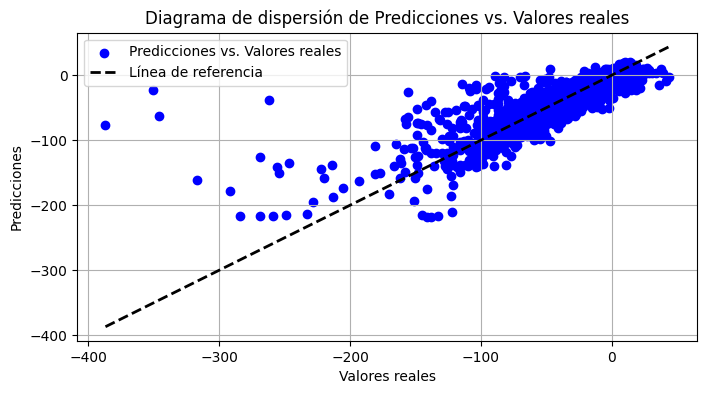

In [47]:
error_nn(preds, y_test, scaler_label)

## 4 Optimización de la selección de hiperparámetros

### Keras tuner

In [48]:
import tensorflow as tf
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    input_shape = x_train.shape[1:]
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=256, step=32)
    mlp_units = [hp.Int(f'mlp_unit_{i}', min_value=32, max_value=256, step=32) for i in range(hp.Int('num_layers', 1, 2))]
    mlp_dropout = hp.Float('mlp_dropout', min_value=0.1, max_value=0.5, step=0.1)
    mlp_activation = hp.Choice('mlp_activation', values=['relu', 'elu', 'tanh'])

    inputs = tf.keras.Input(shape=input_shape)
    seq_1, state_h_1, state_c_1 = tf.keras.layers.LSTM(units=lstm_units, activation='tanh', return_sequences=True, return_state=True)(inputs)
    seq_2, state_h_2, state_c_2 = tf.keras.layers.LSTM(units=lstm_units, activation='tanh', return_sequences=True, return_state=True)(seq_1, initial_state=[state_h_1, state_c_1])

    dec_concat = state_h_2

    for dim in mlp_units:
        dec_concat = tf.keras.layers.Dense(dim, activation=mlp_activation)(dec_concat)
        dec_concat = tf.keras.layers.Dropout(mlp_dropout)(dec_concat)

    output = tf.keras.layers.Dense(1, activation="linear")(dec_concat)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    loss = hp.Choice('loss', values=['mean_squared_error', 'mean_absolute_error'])

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['mae', 'mse'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=70,  # Número de combinaciones de hiperparámetros a probar
    executions_per_trial=2,  # Número de ejecuciones por cada combinación
    directory=f'LSTM_MLP_GRID_SEARCH/{lookforward}h',
    project_name='150_trials'
)

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.4, patience=2, min_lr=0.000001 #0.00001
)

# Supongo que TestMetrics es un callback personalizado que ya has definido
# test_metrics_callback = TestMetrics(x_test, y_test)  # Asegúrate de tener esta clase definida

tuner.search(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, reduce_lr])

tuner.results_summary()

Trial 70 Complete [00h 00m 56s]
val_loss: 0.4159821569919586

Best val_loss So Far: 0.32033571600914
Total elapsed time: 00h 50m 36s
Results summary
Results in LSTM_MLP_GRID_SEARCH/6h/150_trials
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
lstm_units: 256
num_layers: 1
mlp_unit_0: 128
mlp_dropout: 0.4
mlp_activation: tanh
optimizer: adam
loss: mean_absolute_error
mlp_unit_1: 32
Score: 0.32033571600914

Trial 53 summary
Hyperparameters:
lstm_units: 224
num_layers: 1
mlp_unit_0: 224
mlp_dropout: 0.4
mlp_activation: tanh
optimizer: rmsprop
loss: mean_absolute_error
mlp_unit_1: 256
Score: 0.32205210626125336

Trial 45 summary
Hyperparameters:
lstm_units: 192
num_layers: 2
mlp_unit_0: 224
mlp_dropout: 0.2
mlp_activation: elu
optimizer: rmsprop
loss: mean_absolute_error
mlp_unit_1: 96
Score: 0.3261626213788986

Trial 17 summary
Hyperparameters:
lstm_units: 224
num_layers: 2
mlp_unit_0: 160
mlp_dropout: 0.1
mlp_activation: tanh
optimize

In [49]:
# Extraer los resultados
results = tuner.oracle.get_best_trials(num_trials=150)  # Puedes ajustar el número de trials

# Crear una lista de diccionarios para cada trial
trials_list = []

for trial in tuner.oracle.get_best_trials(num_trials=150):
    trial_dict = trial.hyperparameters.values.copy()
    trial_dict['val_loss'] = trial.metrics.get_best_value('val_loss')
    trial_dict['val_mae'] = trial.metrics.get_best_value('val_mae')
    trial_dict['val_mse'] = trial.metrics.get_best_value('val_mse')
    trial_dict['score'] = trial.score
    trials_list.append(trial_dict)

# Crear el DataFrame
results_df = pd.DataFrame(trials_list)

# Mostrar el DataFrame
results_df

,lstm_units,num_layers,mlp_unit_0,mlp_dropout,mlp_activation,optimizer,loss,mlp_unit_1,val_loss,val_mae,val_mse,score
0,256,1,128,0.4,tanh,adam,mean_absolute_error,32,0.320336,0.320336,0.344489,0.320336
1,224,1,224,0.4,tanh,rmsprop,mean_absolute_error,256,0.322052,0.322052,0.327014,0.322052
2,192,2,224,0.2,elu,rmsprop,mean_absolute_error,96,0.326163,0.326163,0.340289,0.326163
3,224,2,160,0.1,tanh,rmsprop,mean_absolute_error,160,0.328631,0.328631,0.378940,0.328631
4,192,1,96,0.1,relu,adam,mean_absolute_error,32,0.329575,0.329575,0.351492,0.329575
...,...,...,...,...,...,...,...,...,...,...,...,...
65,192,1,160,0.1,relu,sgd,mean_squared_error,160,0.472251,0.387086,0.472251,0.472251
66,32,2,64,0.3,relu,rmsprop,mean_squared_error,192,0.480713,0.400662,0.480713,0.480713
67,64,2,96,0.3,relu,rmsprop,mean_squared_error,32,0.485364,0.387967,0.485364,0.485364
68,32,1,224,0.5,relu,sgd,mean_squared_error,224,0.515187,0.399648,0.515187,0.515187


In [50]:
os.makedirs(f"NN_{lookforward}h_res_by_storm/", exist_ok=True)
results_df.to_csv(f"NN_{lookforward}h_res_by_storm/all_data_{lookforward}h_res_LSTM_MLP.csv")

In [51]:
model = build_model_basic(
            x_train.shape[1:],
            lstm_units=224,
            mlp_units=[256,64],
            mlp_dropout=0.3,
            mlp_activation="elu"
            )

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=["MAE", "MSE"])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 12, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 12, 224), │    210,560 │ input_layer_1[0]… │
│                     │ (None, 224),      │            │                   │
│                     │ (None, 224)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 12, 224), │    402,304 │ lstm_2[0][0],     │
│                     │ (None, 224),      │            │ lstm_2[0][1],     │
│                     │ (None, 224)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     57,600 │ lstm_3[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     16,448 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 686,977 (2.62 MB)

 Trainable params: 686,977 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

None


In [52]:
tf.debugging.set_log_device_placement(True)
checkpoint_filepath_loss = "./tmp_weights_models/checkpoints_loss/weighted_old_net.weights.h5"
checkpoint_filepath_mse = "./tmp_weights_models/checkpoints_mse/" + 'weighted_old_net.weights.h5'
checkpoint_filepath_mae = "./tmp_weights_models/checkpoints_mae/" + 'weighted_old_net.weights.h5'

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_mse,
    save_weights_only=True,
    monitor="val_MSE",#"val_mean_absolute_error_labels",#"val_sparse_categorical_accuracy", "val_accuracy"
    mode="min",
    save_best_only=True,
    verbose=1,
)

model_checkpoint_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_loss,
    save_weights_only=True,
    monitor="val_loss",#"val_mean_absolute_error_labels",#"val_sparse_categorical_accuracy", "val_accuracy"
    mode="min",
    save_best_only=True,
    verbose=1,
)

model_checkpoint_callback_mae = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_mae,
    save_weights_only=True,
    monitor="val_MAE",
    mode="min",
    save_best_only=True,
    verbose=1,
)

stop_nan = tf.keras.callbacks.TerminateOnNaN()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.4, patience=1, min_lr=0.000001 #0.00001
)



history = model.fit(
    x_train, y_train,
    epochs=9000,
    validation_data=[x_val, y_val],
    callbacks=[
        model_checkpoint_callback,
        model_checkpoint_callback_loss,
        model_checkpoint_callback_mae,
        es,
        reduce_lr,        
        stop_nan,
    ],
)

Epoch 1/9000
197/200 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - MAE: 0.4517 - MSE: 0.4762 - loss: 0.4762
Epoch 1: val_MSE improved from inf to 0.56031, saving model to ./tmp_weights_models/checkpoints_mse/weighted_old_net.weights.h5

Epoch 1: val_loss improved from inf to 0.56031, saving model to ./tmp_weights_models/checkpoints_loss/weighted_old_net.weights.h5

Epoch 1: val_MAE improved from inf to 0.44963, saving model to ./tmp_weights_models/checkpoints_mae/weighted_old_net.weights.h5
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - MAE: 0.4504 - MSE: 0.4739 - loss: 0.4739 - val_MAE: 0.4496 - val_MSE: 0.5603 - val_loss: 0.5603 - learning_rate: 0.0030
Epoch 2/9000
196/200 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MAE: 0.3454 - MSE: 0.3094 - loss: 0.3094
Epoch 2: val_MSE improved from 0.56031 to 0.47137, saving model to ./tmp_weights_models/checkpoints_mse/weighted_old_net.weights.h5

Epoch 2: val_loss improved from 0.56031 to 0.47137, saving model to ./tmp_weights_models/checkpoints_loss/weighted_old_n

In [53]:
model.load_weights(checkpoint_filepath_loss)
tf.keras.backend.clear_session()
th_moderate_plots = -90

preds = model.predict(x_test)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(2359,)
(2359,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,22.120955,489.336669,12.310633,0.694922,7.598471,0.6975,302.562057


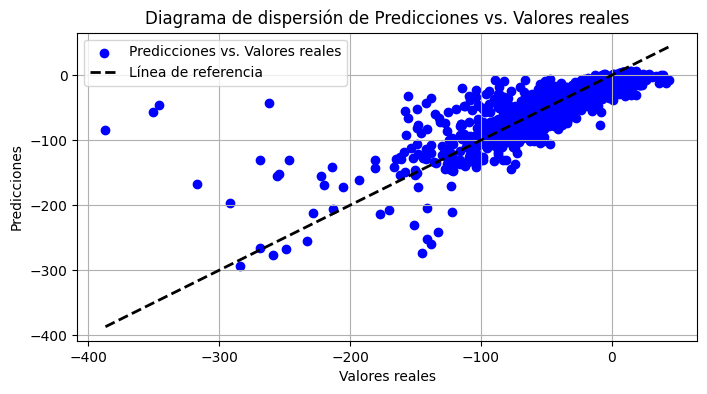

In [54]:
error_nn(preds, y_test, scaler_label)

In [55]:
df_res_nn = pd.DataFrame(
    {
        "y_true": np.squeeze(scaler_label.inverse_transform(y_test.reshape(-1,1))),
        "y_pred": np.squeeze(scaler_label.inverse_transform(preds))
    }
)

In [56]:
os.makedirs(f"NN_{lookforward}h_res_by_storm/", exist_ok=True)
df_res_nn.to_csv(f"NN_{lookforward}h_res_by_storm/all_data_{lookforward}h_res_LSTM_MLP.csv")

In [57]:
def plot_test(df, idx_storm):
    # Crear el gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(df['Datetime_pred'], df['y_pred'], color='red', label='Predicción')
    plt.plot(df['Datetime_pred'], df['y_true'], color='blue', label='Valor Real')
    
    # Añadir título y etiquetas
    date_start = df["Datetime_last_data"].iloc[0].strftime("%Y-%m-%d")
    date_end = df["Datetime_last_data"].iloc[-1].strftime("%Y-%m-%d")
    plt.title(f'Predicción vs Valor Real de la Tormenta [{date_start}]-[{date_end}]')
    plt.xlabel('Fecha')
    plt.ylabel('Dst (nT)')
    plt.legend()
    
    # Mejorar la apariencia
    plt.grid(True)
    plt.xticks(rotation=0)
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.savefig(PATH_NN_RES_BY_STORM_PLOTS.format(lookforward, idx_storm+1), dpi=400)
    plt.show()
    plt.close()


def plot_save_test_storms(test_storms, model, scaler_label):
    for idx_storm, df in enumerate(test_storms):
        x_test, y_test, date_last_data, date_pred = create_window_df_nn_test([df], lookback, lookforward, cols_to_use, col_to_predict, scaler_cols)
        print("x_test shape : ", x_test.shape, "\ny_test shape:", y_test.shape)

        preds = model.predict(x_test)
        preds_unscaled = scaler_label.inverse_transform(preds)
        y_test_unscaled = scaler_label.inverse_transform(y_test.reshape(-1,1))
        df_to_save = pd.DataFrame(
            {
                "Datetime_last_data": date_last_data,
                "Datetime_pred": date_pred,
                "y_true": np.squeeze(y_test_unscaled),
                "y_pred": np.squeeze(preds_unscaled),
            }
        )
        
        file_path = PATH_NN_RES_BY_STORM.format(lookforward, idx_storm+1)
        folder_path = os.path.dirname(file_path)
        os.makedirs(folder_path, exist_ok=True)
        df_to_save.to_csv(file_path)
        plot_test(df_to_save, idx_storm)
        error_nn(preds, y_test, scaler_label)

x_test shape :  (223, 12, 10) 
y_test shape: (223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


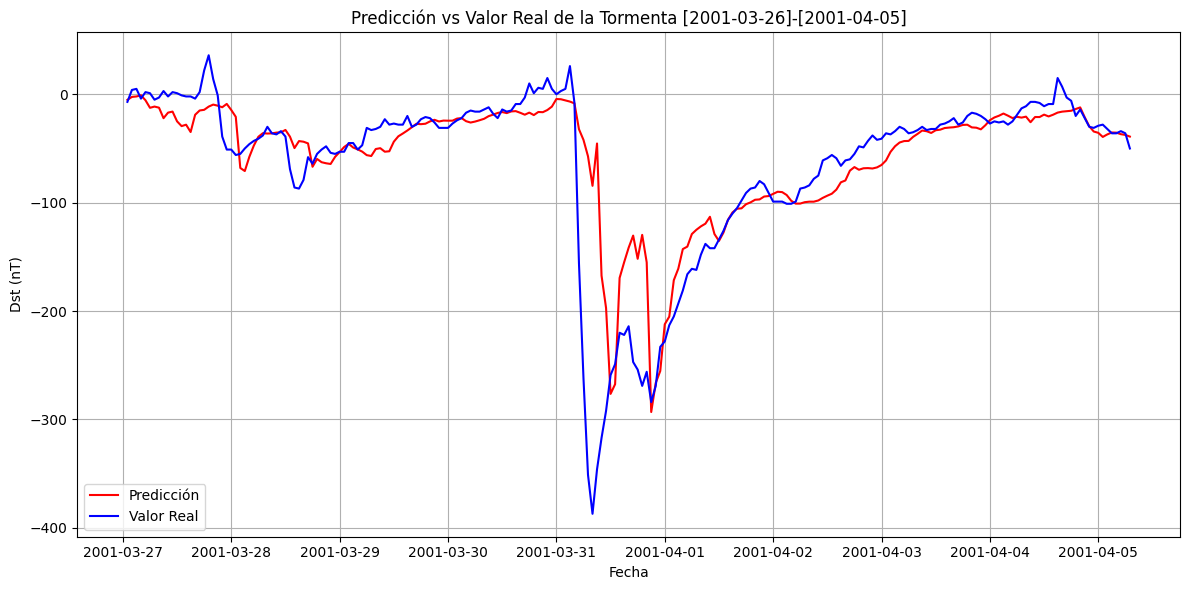

(223,)
(223,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,46.794725,2189.746328,21.587154,0.638513,10.754124,0.641589,302.562057


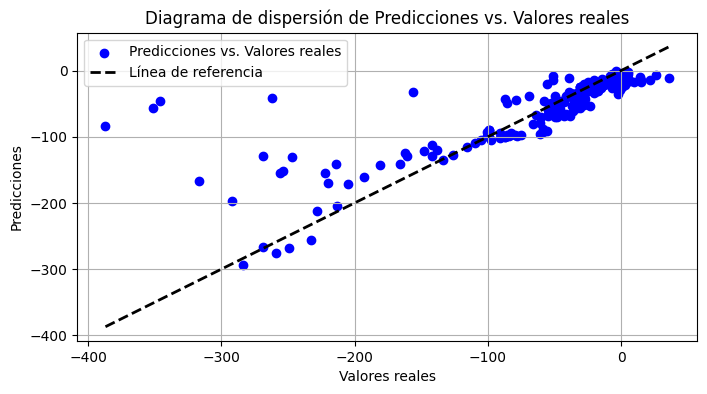

x_test shape :  (328, 12, 10) 
y_test shape: (328,)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


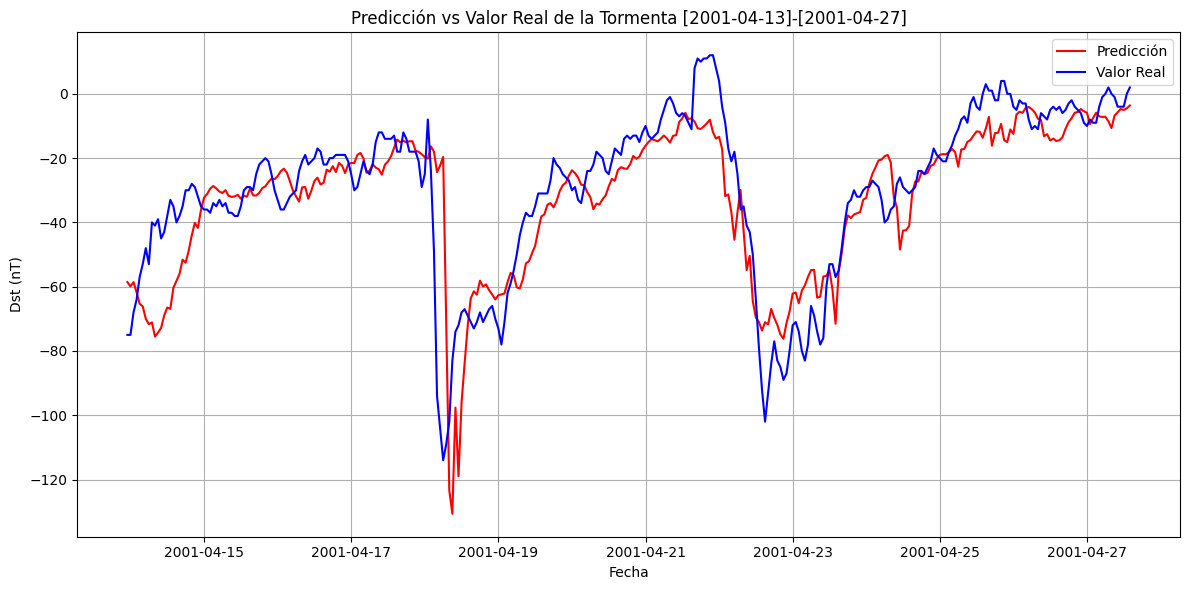

(328,)
(328,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,14.419283,207.915727,9.926346,0.676623,7.440244,0.689937,94.40324


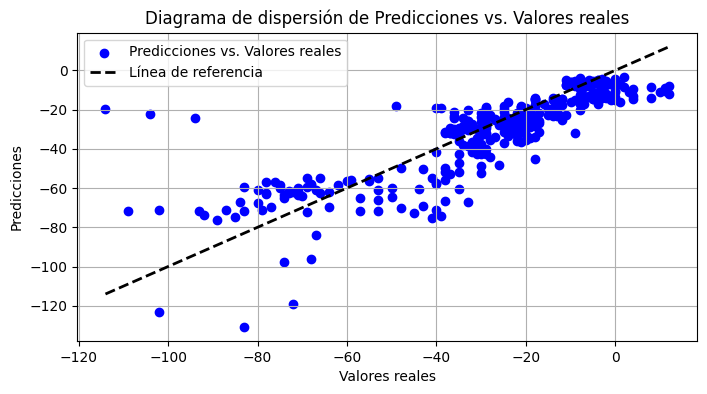

x_test shape :  (272, 12, 10) 
y_test shape: (272,)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


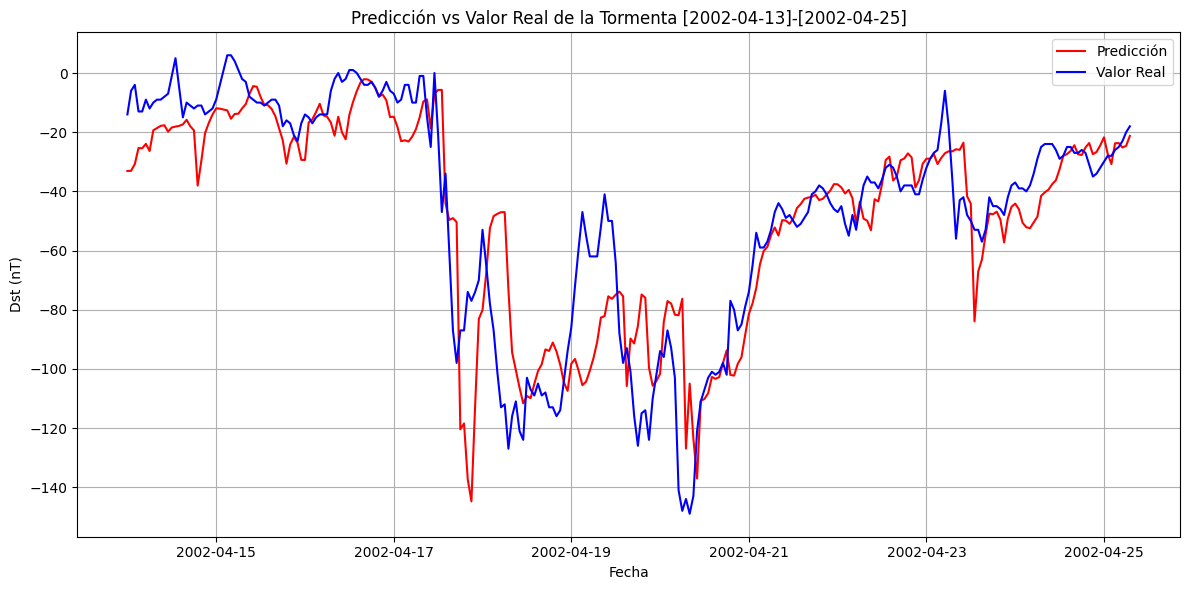

(272,)
(272,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,18.80966,353.803295,12.943138,0.75397,9.031412,0.757766,71.691757


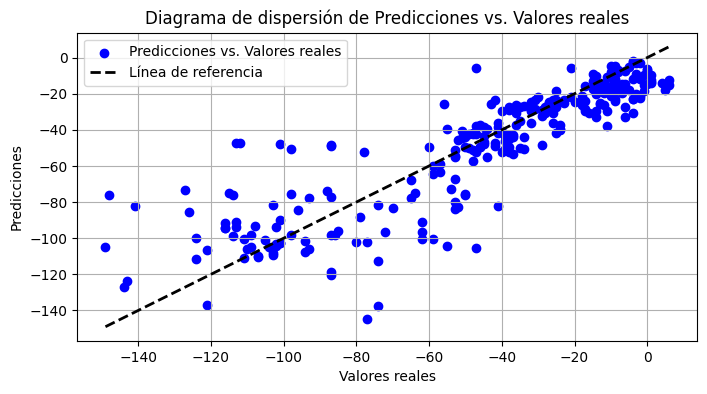

x_test shape :  (314, 12, 10) 
y_test shape: (314,)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


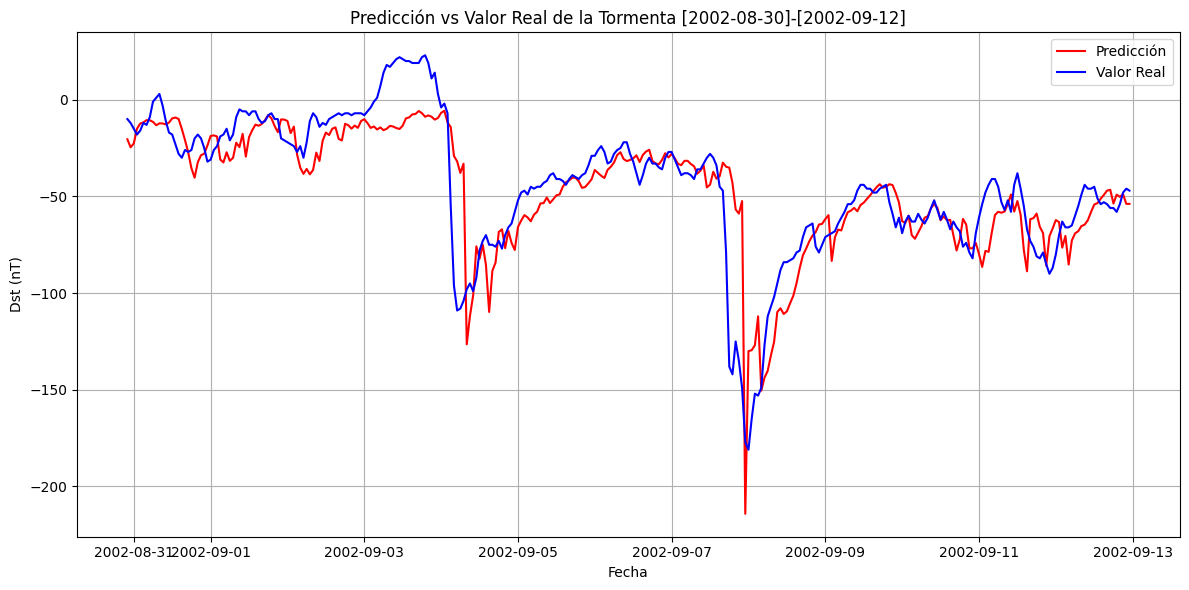

(314,)
(314,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,20.008599,400.344029,13.189675,0.685301,9.273971,0.692332,102.875072


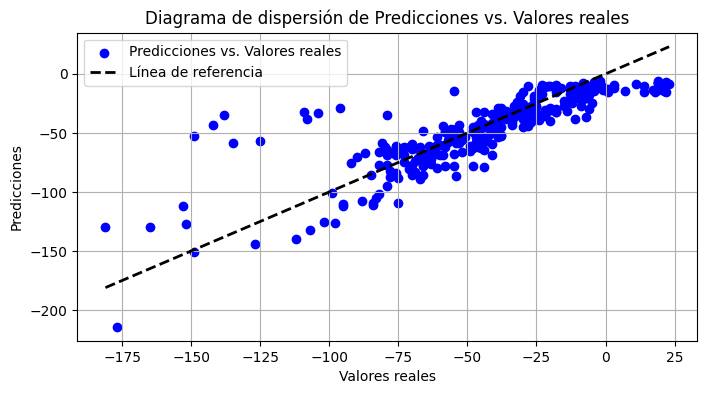

x_test shape :  (330, 12, 10) 
y_test shape: (330,)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


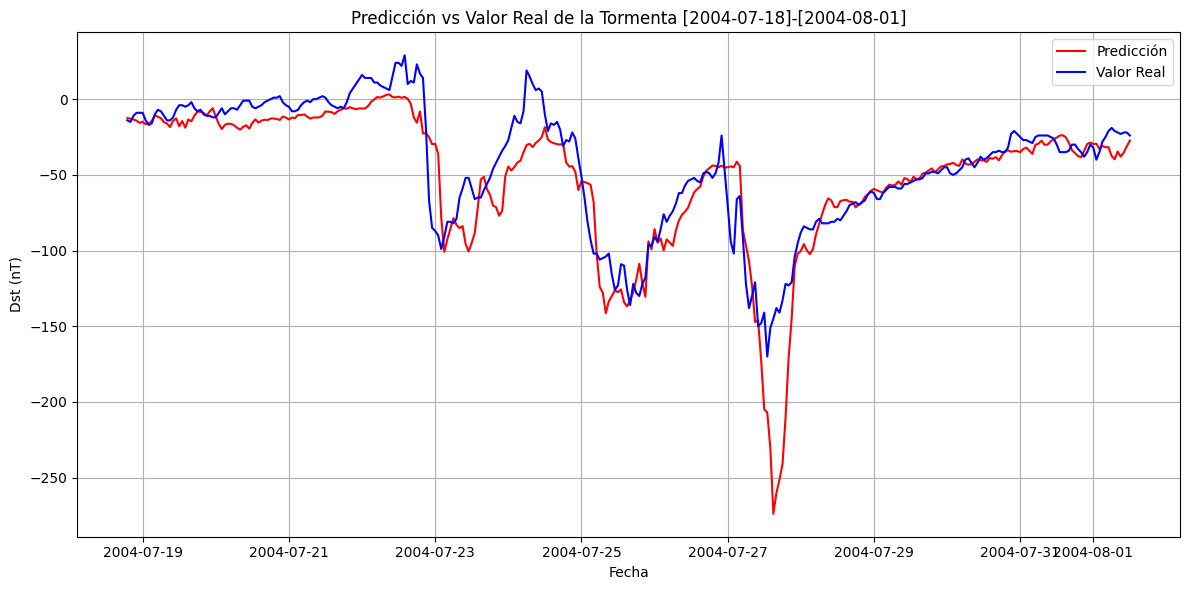

(330,)
(330,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,22.163044,491.200527,13.666572,0.710515,8.609686,0.747731,128.863739


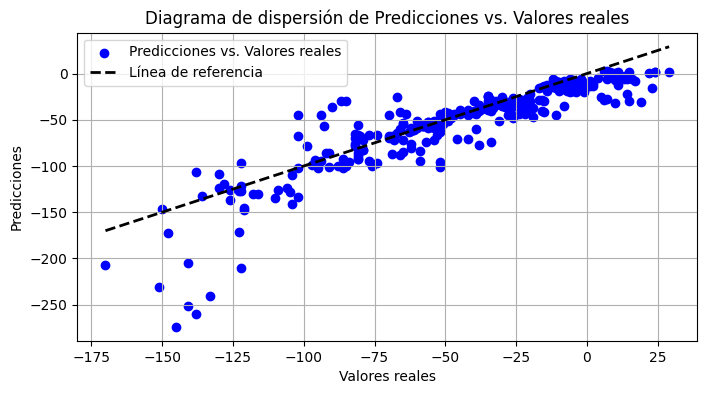

x_test shape :  (223, 12, 10) 
y_test shape: (223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


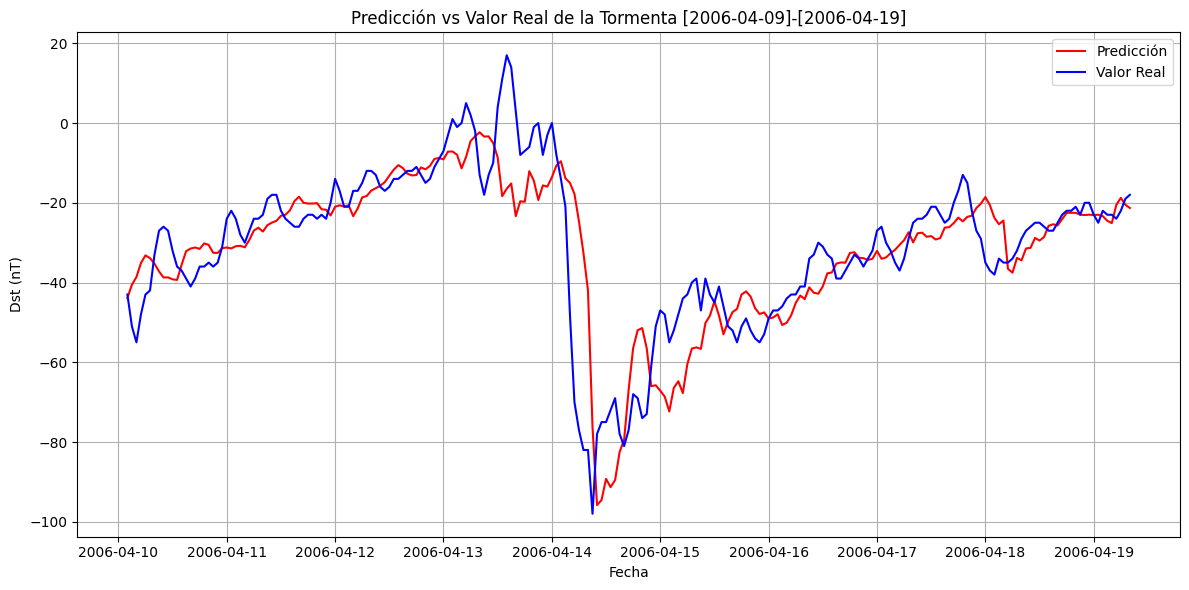

(223,)
(223,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,11.402238,130.011036,7.657373,0.657359,4.986828,0.66095,52.318331


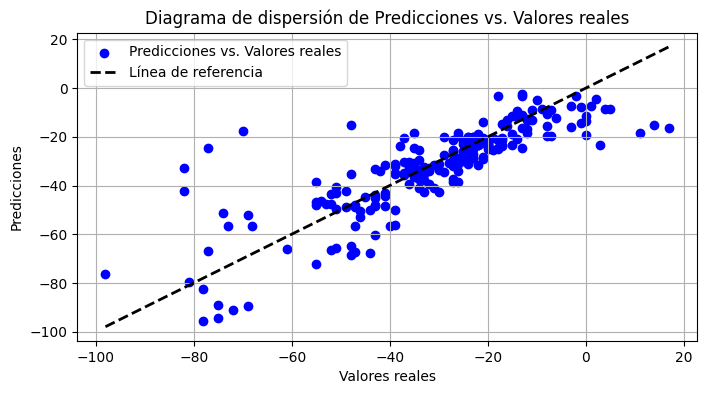

x_test shape :  (223, 12, 10) 
y_test shape: (223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


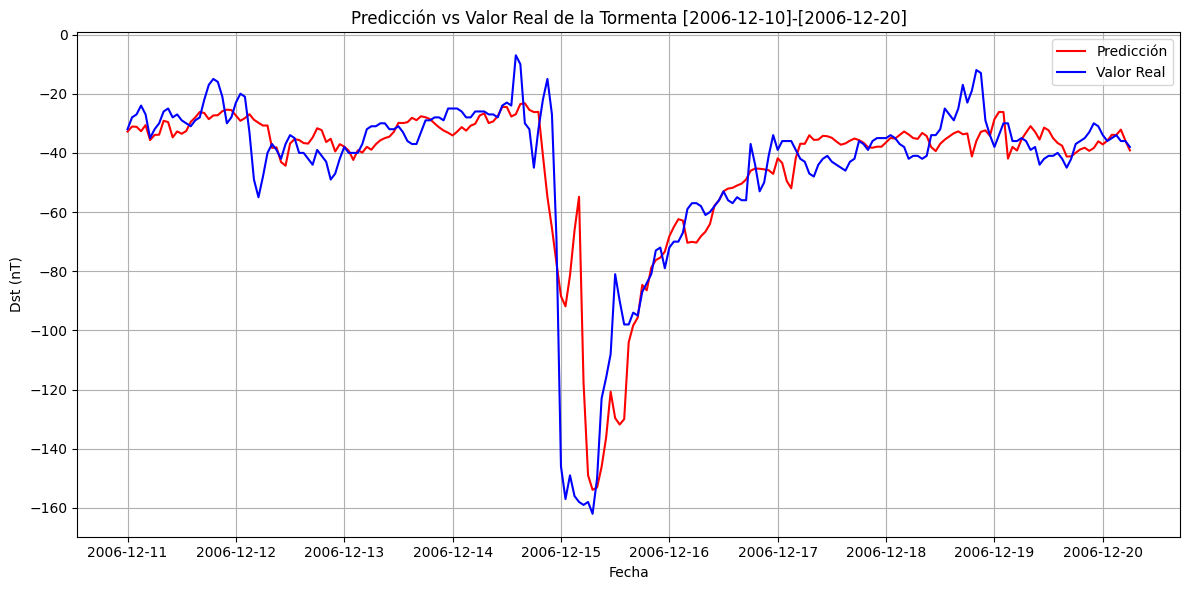

(223,)
(223,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,15.49506,240.096887,8.487397,0.712545,5.12751,0.712695,103.143173


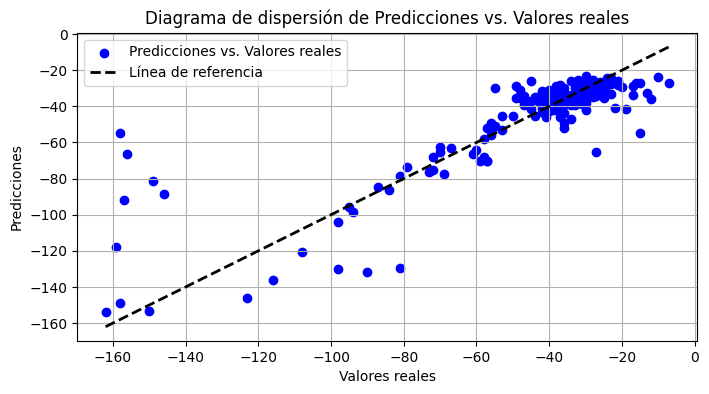

x_test shape :  (223, 12, 10) 
y_test shape: (223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


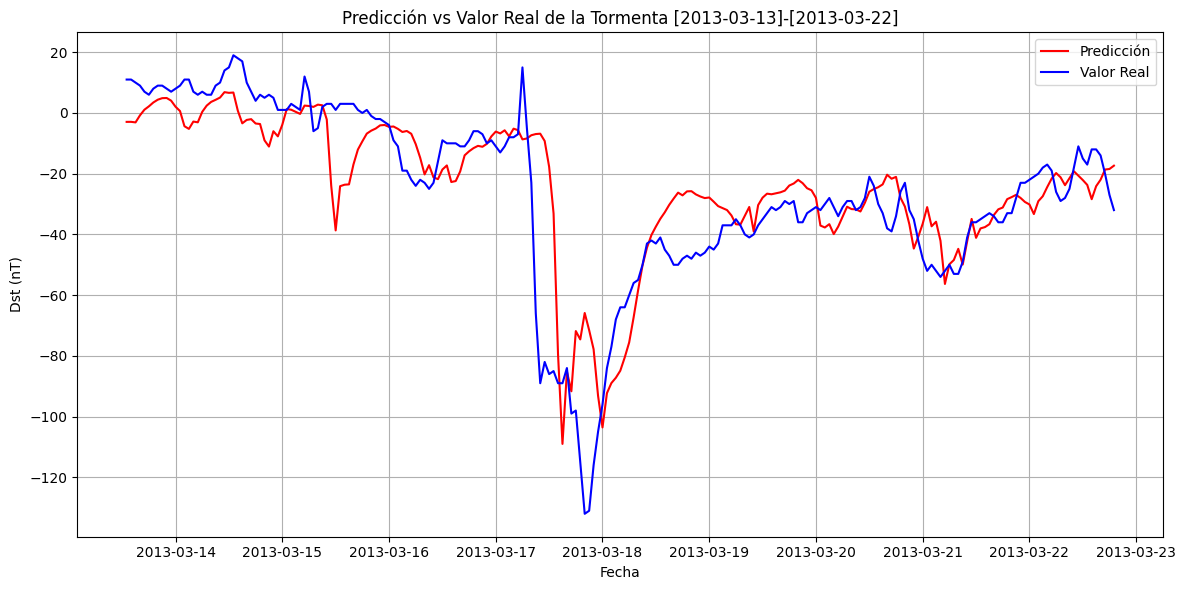

(223,)
(223,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,16.230936,263.44327,10.541007,0.689865,7.275415,0.692132,82.171608


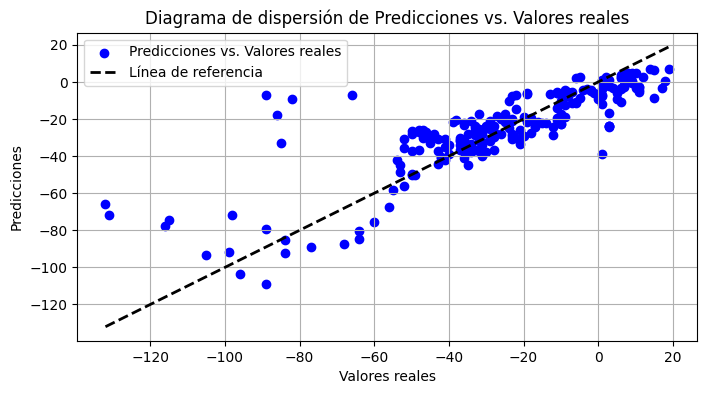

x_test shape :  (223, 12, 10) 
y_test shape: (223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


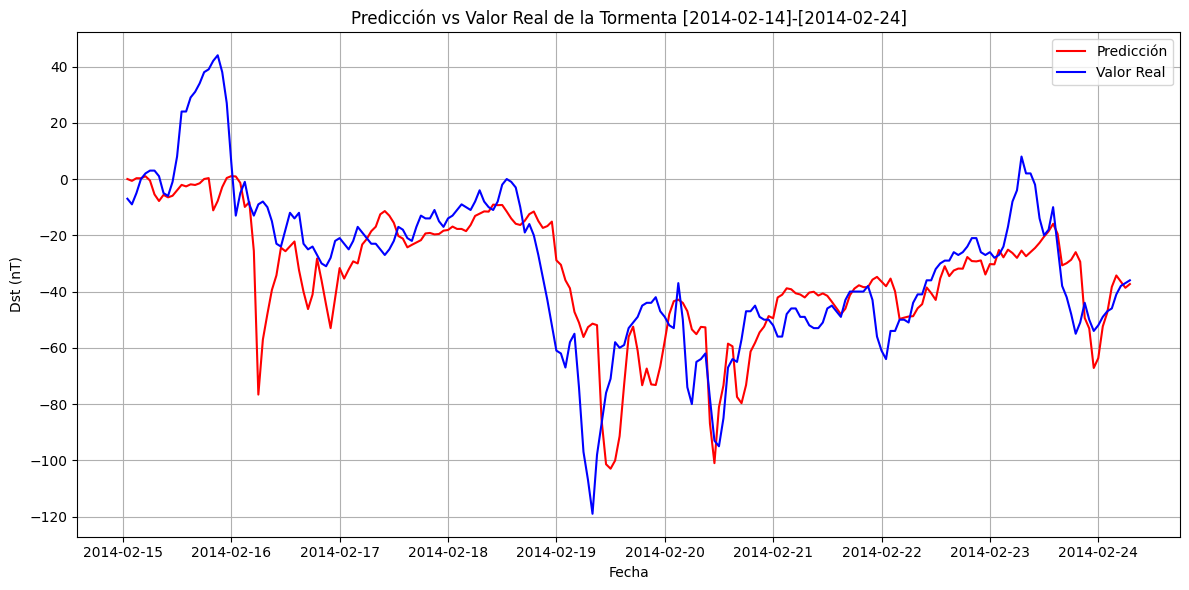

(223,)
(223,)


Métrica,RMSE,MSE,MAE,R²,MedAE,Varianza explicada,Max error
Valor,18.032706,325.178483,12.771383,0.573362,8.290066,0.587444,67.622208


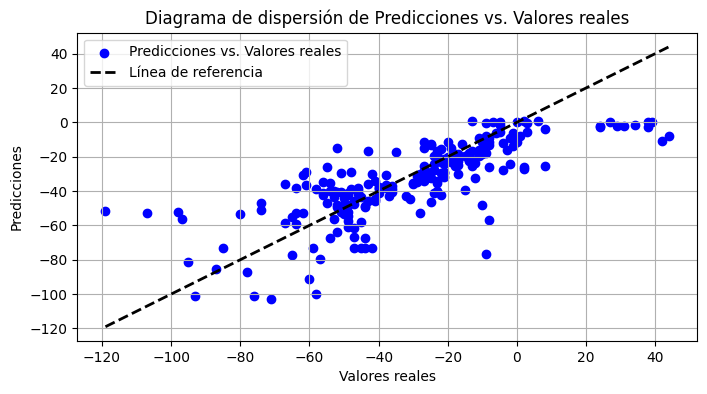

In [58]:
plot_save_test_storms(test_storms, model, scaler_label)